<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 161197304 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 5499459 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,53.420228,-2.966120,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,53.502594,-2.516861,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,51.674615,-3.212091,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,53.245090,-3.123599,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,53.734079,-2.140287,95000.0


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,53.642111,-1.748224,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,52.445938,-1.924921,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,52.327517,-1.079233,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,52.486194,-1.966257,660000.0


In [6]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1500000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1500000) ]

In [7]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [8]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [10]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
526484,3,2,2,8.0,49.838926,1.091699,11.0,10.7,10.1,96666.66667,99375.00000,16,10251914000,29087721000,17731602000,50.929878,-1.307435,280000.0
534545,3,2,3,1.0,0.000000,0.000000,0.0,0.0,0.0,50833.33333,55416.66667,7,23573996000,23641176000,15694259000,51.513474,-3.574608,185950.0
917697,4,2,4,9.0,70.261965,1.087907,27.0,10.7,8.0,54958.33333,59333.33333,8,24980859900,1603296000,10903559000,53.459381,-2.011784,283000.0
384793,3,2,4,12.0,85.739481,0.760311,88.0,1.6,2.3,96666.66667,100500.00000,9,14362712000,30647054000,19389627000,50.738074,-1.813810,467500.0
822224,3,2,3,8.0,87.668522,0.842686,35.0,8.4,7.5,80000.00000,84333.33333,4,6958214000,19403159000,10641854000,52.112291,-0.461080,239000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021975,4,2,4,15.0,49.459725,1.471237,11.0,10.3,9.5,115250.00000,117916.66670,11,5423130000,28895105000,20084898000,51.553553,0.613684,437500.0
283512,2,2,2,1.0,0.000000,0.000000,0.0,0.0,0.0,64983.33333,65000.00000,10,21687330900,24204736000,15335498000,51.398882,-3.292576,148000.0
577473,3,1,1,37.0,64.205172,1.091816,37.0,11.5,10.5,263333.33330,186750.00000,24,912859000,25167681000,15290678000,51.593341,-0.197696,262000.0
496440,3,2,3,28.0,123.303153,1.117733,74.0,0.5,0.6,32333.33333,26666.66667,12,28507801000,4540474000,12754750000,53.446007,-2.934604,65000.0


In [12]:
dataset = df_train_test_data.values
dataset

array([[3, '2', '2', ..., 50.929878, -1.3074350000000001, 280000.0],
       [3, '2', '3', ..., 51.513474, -3.574608, 185950.0],
       [4, '2', '4', ..., 53.45938100000001, -2.011784, 283000.0],
       ...,
       [3, '1', '1', ..., 51.593340999999995, -0.197696, 262000.0],
       [3, '2', '3', ..., 53.446006999999994, -2.934604, 65000.0],
       [2, '2', '2', ..., 51.538894, 0.13527, 315000.0]], dtype=object)

In [13]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [14]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [21]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [16]:
from sklearn import preprocessing

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()

In [18]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 0.33333333, ..., 0.4708406 , 0.16580958,
        0.58926079],
       [0.5       , 1.        , 0.66666667, ..., 0.41653425, 0.26604504,
        0.28534747],
       [0.75      , 1.        , 1.        , ..., 0.28883585, 0.60026406,
        0.49484318],
       ...,
       [0.5       , 0.        , 0.        , ..., 0.4057766 , 0.27976259,
        0.7380207 ],
       [0.5       , 1.        , 0.66666667, ..., 0.33818023, 0.59796701,
        0.37113966],
       [0.25      , 1.        , 0.33333333, ..., 0.4635109 , 0.27041105,
        0.78265462]])

In [19]:

print(min(Y1))
print(max(Y1))

12000.0
1499999.0


In [22]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44339255, 0.2545847 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45716693, 0.27486414,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.50538858, 0.14881873,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51753351, 0.31527428,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58441786, 0.14948033,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62355058, 0.13975626,
        0.77824104]])

In [23]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
1495000.0


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [26]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(1010056, 17) (112229, 17) (1010056,) (112229,)


In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [29]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [31]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,5.0,2.0,4.0,3.0,13.635409,3.593972,16.0,9.8,10.0,172500.00000,141666.66670,17.0,2.987428e+09,2.556106e+10,1.489655e+10,51.422151,-0.573315,1.351e+06,1.019561e+06,331439,1.09852e+11,331439,29874280_255610590_148965480
1,2.0,2.0,3.0,10.0,71.343315,0.424740,36.0,8.5,8.3,96666.66667,98750.00000,23.0,4.404623e+09,2.174814e+10,1.230458e+10,51.886324,-0.383079,275000,2.411418e+05,33858.2,1.14638e+09,33858.2,44046230_217481350_123045750
2,3.0,2.0,3.0,12.0,109.278290,1.649415,47.0,9.6,8.0,41666.66667,44000.00000,11.0,2.524828e+10,1.332882e+10,1.802642e+10,53.782699,-0.294698,148000,1.302058e+05,17794.2,3.16635e+08,17794.2,252482820_133288209_180264220
3,5.0,2.0,4.0,11.0,41.108761,1.348014,13.0,9.7,8.2,102916.66670,102916.66670,2.0,5.703666e+09,3.108254e+10,2.159399e+10,51.273557,0.558986,470000,5.853951e+05,-115395,1.3316e+10,115395,57036660_310825380_215939890
4,2.0,2.0,2.0,12.0,63.636388,0.666894,17.0,10.2,8.7,53333.33333,53333.33333,3.0,2.623748e+10,4.240540e+09,1.340959e+10,53.680776,-1.703953,83250,1.059471e+05,-22697.1,5.15157e+08,22697.1,262374809_42405400_134095930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112224,3.0,2.0,2.0,14.0,53.620826,1.357582,20.0,10.1,8.7,58000.00000,58000.00000,2.0,2.281875e+10,4.866563e+09,1.040584e+10,53.389410,-1.532895,135000,1.443408e+05,-9340.81,8.72507e+07,9340.81,228187500_48665630_104058400
112225,3.0,2.0,4.0,3.0,24.560289,2.331012,8.0,9.1,9.0,135000.00000,143333.33330,15.0,5.286798e+09,3.022651e+10,1.948918e+10,51.043586,-0.284377,469750,4.636572e+05,6092.84,3.71227e+07,6092.84,52867980_302265120_194891790
112226,3.0,2.0,2.0,14.0,75.266416,0.927245,4.0,12.6,11.9,38125.00000,37500.00000,7.0,2.146253e+10,5.429028e+09,6.022103e+09,52.994237,-2.190375,160000,1.029868e+05,57013.2,3.25051e+09,57013.2,214625270_54290280_60221030
112227,2.0,2.0,2.0,8.0,25.525513,1.060476,20.0,8.3,7.2,102083.33330,102083.33330,2.0,4.720615e+09,3.010345e+10,2.058612e+10,51.331460,0.447445,245000,2.367670e+05,8233.03,6.77828e+07,8233.03,47206150_301034480_205861190


In [32]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,5.0,2.0,4.0,3.0,13.635409,3.593972,16.0,9.8,10.0,172500.00000,141666.66670,17.0,2.987428e+09,2.556106e+10,1.489655e+10,51.422151,-0.573315,1.351e+06,1.019561e+06,331439,1.09852e+11,331439,29874280_255610590_148965480,TW20 0BA,RUNNYMEDE,TW20
1,2.0,2.0,3.0,10.0,71.343315,0.424740,36.0,8.5,8.3,96666.66667,98750.00000,23.0,4.404623e+09,2.174814e+10,1.230458e+10,51.886324,-0.383079,275000,2.411418e+05,33858.2,1.14638e+09,33858.2,44046230_217481350_123045750,LU2 9HP,LUTON,LU2
2,3.0,2.0,3.0,12.0,109.278290,1.649415,47.0,9.6,8.0,41666.66667,44000.00000,11.0,2.524828e+10,1.332882e+10,1.802642e+10,53.782699,-0.294698,148000,1.302058e+05,17794.2,3.16635e+08,17794.2,252482820_133288209_180264220,HU8 9JZ,CITY OF KINGSTON UPON HULL,HU8
3,5.0,2.0,4.0,11.0,41.108761,1.348014,13.0,9.7,8.2,102916.66670,102916.66670,2.0,5.703666e+09,3.108254e+10,2.159399e+10,51.273557,0.558986,470000,5.853951e+05,-115395,1.3316e+10,115395,57036660_310825380_215939890,ME14 5TH,MAIDSTONE,ME14
4,2.0,2.0,2.0,12.0,63.636388,0.666894,17.0,10.2,8.7,53333.33333,53333.33333,3.0,2.623748e+10,4.240540e+09,1.340959e+10,53.680776,-1.703953,83250,1.059471e+05,-22697.1,5.15157e+08,22697.1,262374809_42405400_134095930,WF14 9BG,KIRKLEES,WF14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112224,3.0,2.0,2.0,14.0,53.620826,1.357582,20.0,10.1,8.7,58000.00000,58000.00000,2.0,2.281875e+10,4.866563e+09,1.040584e+10,53.389410,-1.532895,135000,1.443408e+05,-9340.81,8.72507e+07,9340.81,228187500_48665630_104058400,S6 5QA,SHEFFIELD,S6
112225,3.0,2.0,4.0,3.0,24.560289,2.331012,8.0,9.1,9.0,135000.00000,143333.33330,15.0,5.286798e+09,3.022651e+10,1.948918e+10,51.043586,-0.284377,469750,4.636572e+05,6092.84,3.71227e+07,6092.84,52867980_302265120_194891790,RH13 6JE,HORSHAM,RH13
112226,3.0,2.0,2.0,14.0,75.266416,0.927245,4.0,12.6,11.9,38125.00000,37500.00000,7.0,2.146253e+10,5.429028e+09,6.022103e+09,52.994237,-2.190375,160000,1.029868e+05,57013.2,3.25051e+09,57013.2,214625270_54290280_60221030,ST4 5BX,STOKE-ON-TRENT,ST4
112227,2.0,2.0,2.0,8.0,25.525513,1.060476,20.0,8.3,7.2,102083.33330,102083.33330,2.0,4.720615e+09,3.010345e+10,2.058612e+10,51.331460,0.447445,245000,2.367670e+05,8233.03,6.77828e+07,8233.03,47206150_301034480_205861190,ME6 5FD,TONBRIDGE AND MALLING,ME6


In [33]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [34]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

68010.34111292855

In [36]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :38.14522093220113 %
Predictions where error is 15% or less :53.64477986973064 %
Predictions where error is 20% or less :66.00700353741011 %
Predictions where error is 50% or more :5.695497598659883 %


In [37]:
prediction_validation=regr1.predict(X_Validation_scale)

In [39]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,427227.984167,113228,1.28206e+10,113228,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,203966.857642,-21033.1,4.42393e+08,21033.1,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,122768.919366,2768.92,7.66691e+06,2768.92,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,408124.041770,-91876,8.44119e+09,91876,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,51273.244497,-726.756,528174,726.756,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37934,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,388519.592457,71519.6,5.11505e+09,71519.6,148740500_304966640_192878440
37935,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,366454.193488,-27295.8,7.45061e+08,27295.8,228863930_47702200_72125650
37936,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,585276.344498,25276.3,6.38894e+08,25276.3,69380650_274338630_194833210
37937,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,735128.970705,193129,3.72988e+10,193129,75486840_327653040_219925370


In [40]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,427227.984167,113228,1.28206e+10,113228,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,203966.857642,-21033.1,4.42393e+08,21033.1,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,122768.919366,2768.92,7.66691e+06,2768.92,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,408124.041770,-91876,8.44119e+09,91876,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,51273.244497,-726.756,528174,726.756,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37934,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,388519.592457,71519.6,5.11505e+09,71519.6,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
37935,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,366454.193488,-27295.8,7.45061e+08,27295.8,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
37936,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,585276.344498,25276.3,6.38894e+08,25276.3,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
37937,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,735128.970705,193129,3.72988e+10,193129,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [41]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [42]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

68911.70713964902

In [43]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :37.3942381190859 %
Predictions where error is 15% or less :52.39463349060334 %
Predictions where error is 20% or less :64.68541606262684 %
Predictions where error is 50% or more :6.012282875141675 %


In [44]:
import matplotlib.pyplot as plt

In [45]:
import numpy as np

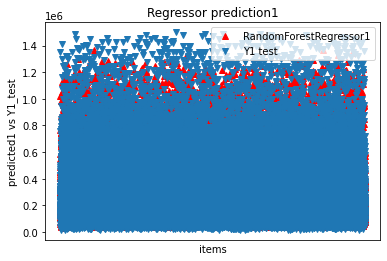

In [46]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

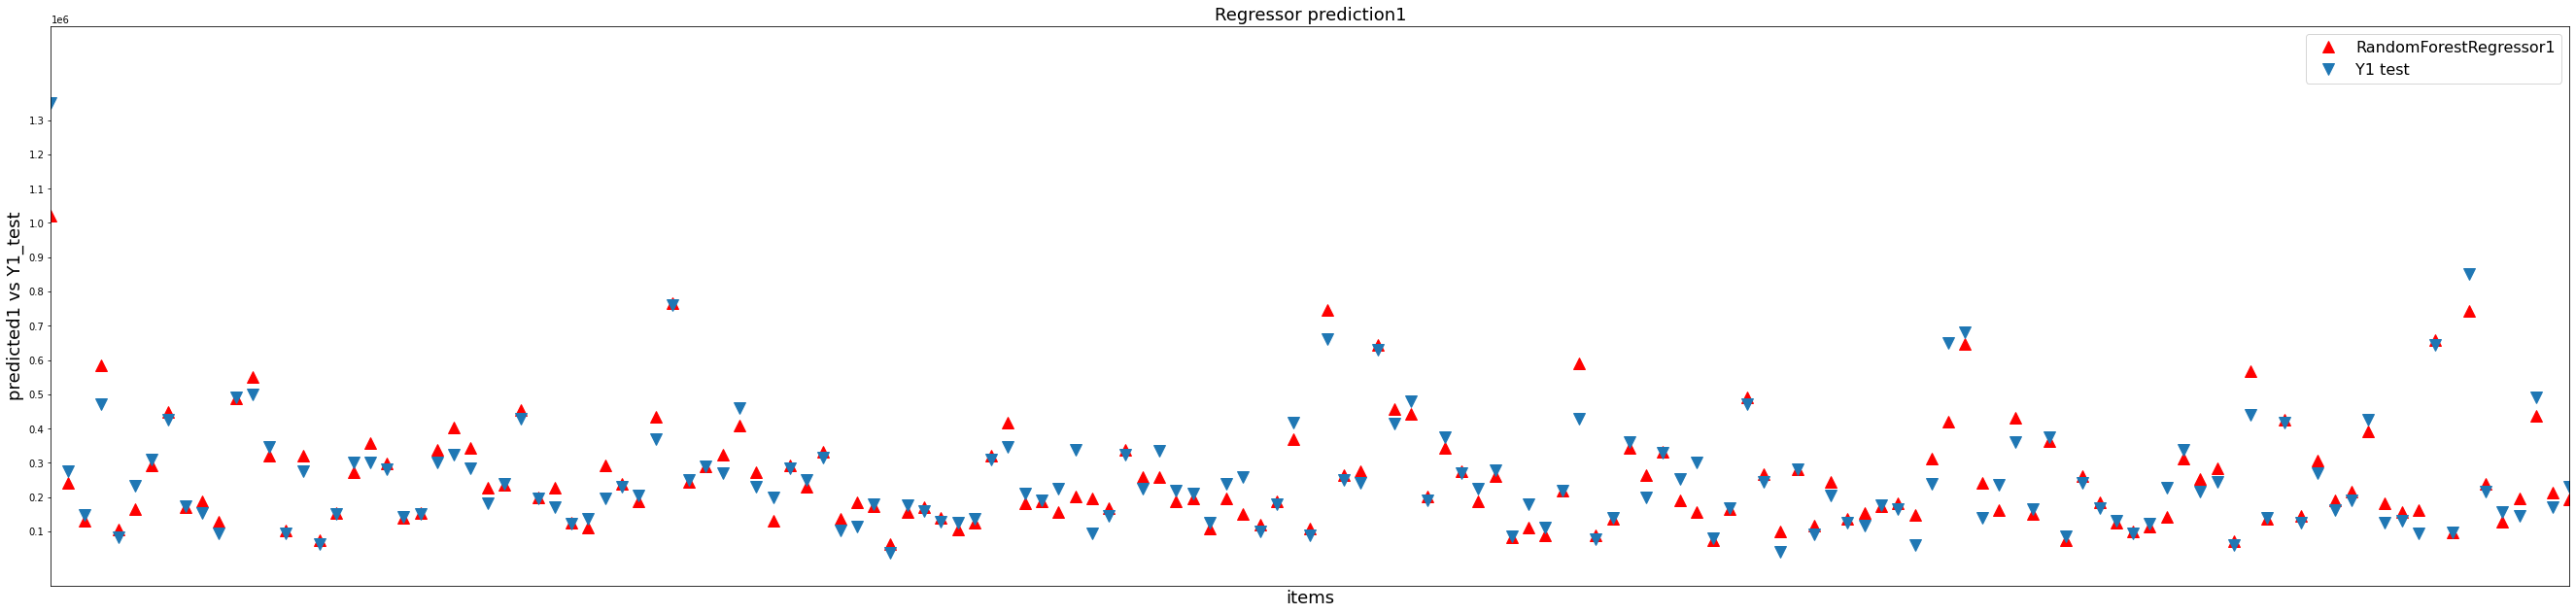

In [47]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [48]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [49]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

68010.34111292892

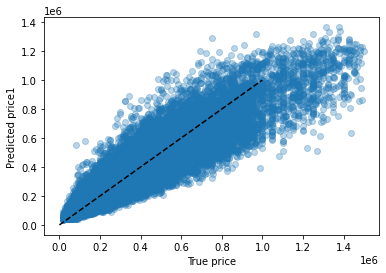

In [50]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [51]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

68911.70713964908

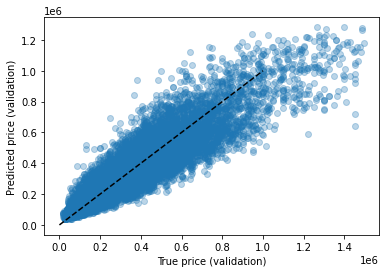

In [52]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()